Data from: https://www.kaggle.com/mansoordaku/ckdisease

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re

import scipy.stats as sc_stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

In [2]:
def auc_scorer(clf, X, y, model): 
    
    fpr, tpr, _ = roc_curve( y, clf.decision_function(X) ) 
        
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, 
             label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.show()

    return fpr,tpr,roc_auc

def obtain_stats(col_x):
    dict_result = dict()
    
    dict_result["min"] = np.nanmin( col_x )
    dict_result["perct25"] = np.nanpercentile( col_x, 25 )
    dict_result["mean"] = np.nanmean( col_x )
    dict_result["median"] = np.nanmedian( col_x )
    dict_result["std"] = np.nanstd( col_x )
    dict_result["perct75"] = np.nanpercentile( col_x, 75 )
    dict_result["max"] = np.nanmax( col_x )
    
    return dict_result

In [3]:
df = pd.read_csv('data/kidney_disease.csv')

In [4]:
print( "Columns", df.columns )
print( "Data frame shape", df.shape )

Columns Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')
Data frame shape (400, 26)


In [5]:
type_var_dict = dict()
for col in df.columns:
    type_var_dict[col] = df[col].dtype.name
    
print("Table of variables type")
var_type_df = pd.DataFrame(type_var_dict, index=[0])
print( var_type_df )

print("Number of variable of type int64", np.sum(var_type_df.T == "int64"))
print("Number of variable of type float64", np.sum(var_type_df.T == "float64"))
print("Number of variable of type object", np.sum(var_type_df.T == "object"))

Table of variables type
      id      age       bp       sg       al       su     rbc      pc     pcc  \
0  int64  float64  float64  float64  float64  float64  object  object  object   

       ba  ...     pcv      wc      rc     htn      dm     cad   appet  \
0  object  ...  object  object  object  object  object  object  object   

       pe     ane classification  
0  object  object         object  

[1 rows x 26 columns]
Number of variable of type int64 0    1
dtype: int64
Number of variable of type float64 0    11
dtype: int64
Number of variable of type object 0    14
dtype: int64


In [6]:
problem_columns = ["pcv", "wc", "rc", "dm", "cad", "classification"]
characters = ["\t"]
for col in problem_columns:
    
    new_colum_list = list()
    for val in df[col].values:
            
        try:    
            if "\t?" in val:
                new_colum_list.append( np.nan )

            elif "\t" in val:
                x = re.sub("\t", "")
                new_colum_list.append( x )

            else:
                new_colum_list.append( val )
        except:
            new_colum_list.append( np.nan )
            
    df[col] = new_colum_list

columns_numeric = ["pcv", "wc", "rc"]
for col in columns_numeric:
    df[col] = pd.to_numeric( df[col] )

In [7]:
for col in df.columns:
    print("Column", col)
    try:
        print( obtain_stats(df[col].values) )
    except:
        print( set(df[col].values) )

Column id
{'min': 0, 'perct25': 99.75, 'mean': 199.5, 'median': 199.5, 'std': 115.46969299344309, 'perct75': 299.25, 'max': 399}
Column age
{'min': 2.0, 'perct25': 42.0, 'mean': 51.48337595907928, 'median': 55.0, 'std': 17.147743876694122, 'perct75': 64.5, 'max': 90.0}
Column bp
{'min': 50.0, 'perct25': 70.0, 'mean': 76.46907216494846, 'median': 80.0, 'std': 13.665992563563378, 'perct75': 80.0, 'max': 180.0}
Column sg
{'min': 1.005, 'perct25': 1.01, 'mean': 1.0174079320113314, 'median': 1.02, 'std': 0.00570851404050285, 'perct75': 1.02, 'max': 1.025}
Column al
{'min': 0.0, 'perct25': 0.0, 'mean': 1.0169491525423728, 'median': 0.0, 'std': 1.3507669981496595, 'perct75': 2.0, 'max': 5.0}
Column su
{'min': 0.0, 'perct25': 0.0, 'mean': 0.45014245014245013, 'median': 0.0, 'std': 1.0976243355479867, 'perct75': 0.0, 'max': 5.0}
Column rbc
{nan, 'abnormal', 'normal'}
Column pc
{nan, 'abnormal', 'normal'}
Column pcc
{nan, 'present', 'notpresent'}
Column ba
{nan, 'present', 'notpresent'}
Column b

In [8]:
dict_nan_col = dict( np.sum(df.isna()) )
print( "Dictionary of nans per column", dict_nan_col )

rate_nan = 0.2

good_columns = list()

for key in dict_nan_col.keys():
    if dict_nan_col[key] <= rate_nan*df.shape[0]:
        good_columns.append( key )

Dictionary of nans per column {'id': 0, 'age': 9, 'bp': 12, 'sg': 47, 'al': 46, 'su': 49, 'rbc': 152, 'pc': 65, 'pcc': 4, 'ba': 4, 'bgr': 44, 'bu': 19, 'sc': 17, 'sod': 87, 'pot': 88, 'hemo': 52, 'pcv': 72, 'wc': 108, 'rc': 131, 'htn': 2, 'dm': 7, 'cad': 4, 'appet': 1, 'pe': 1, 'ane': 1, 'classification': 2}


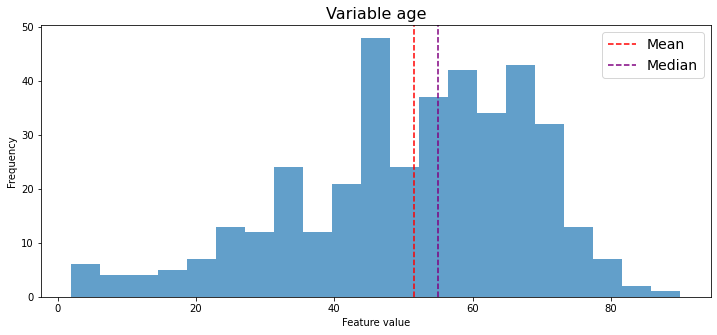

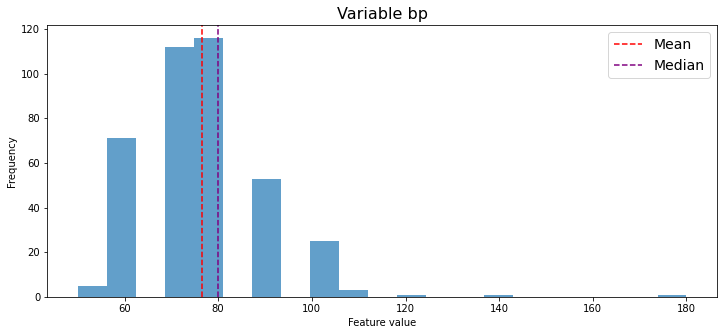

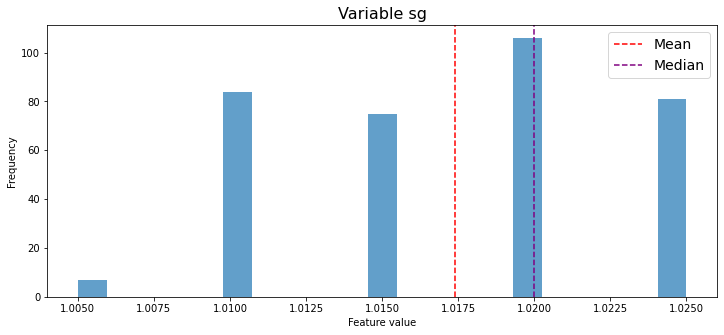

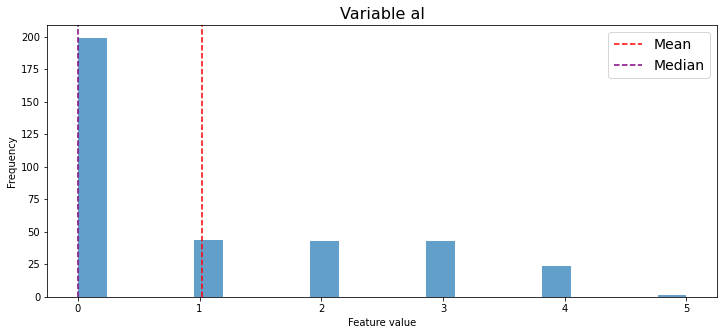

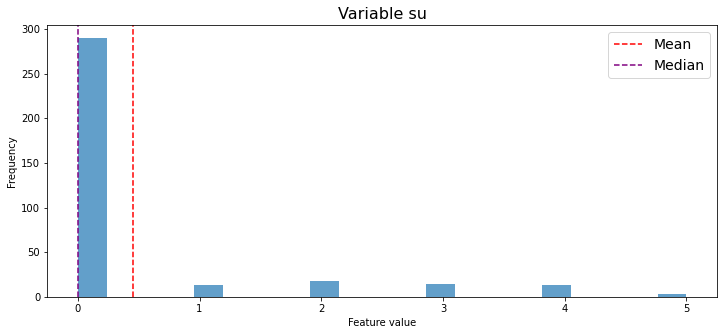

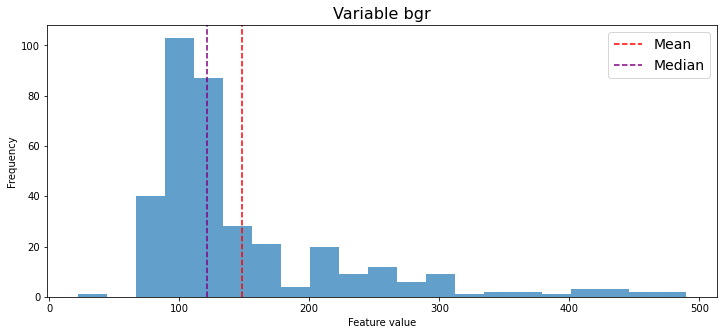

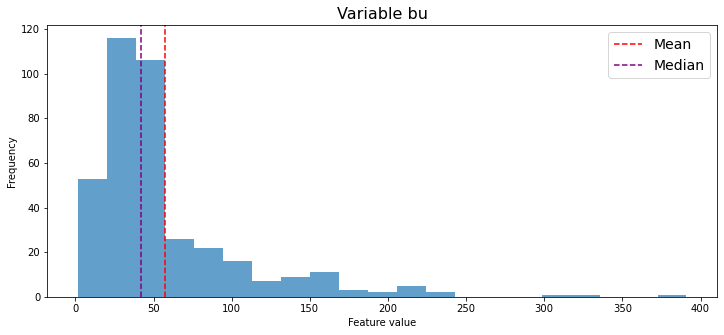

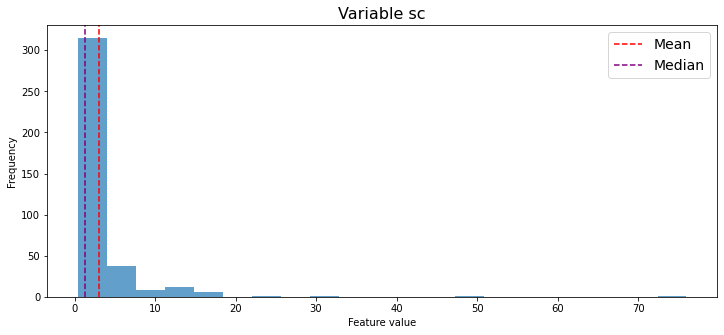

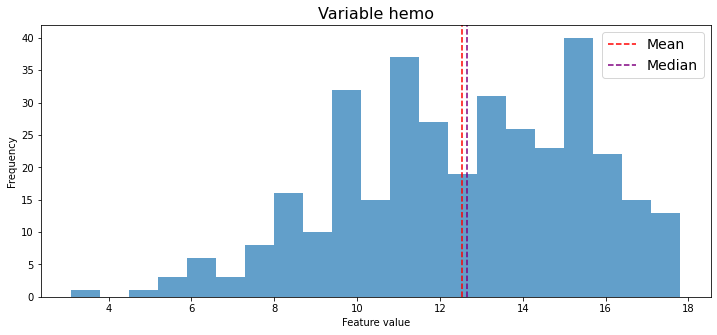

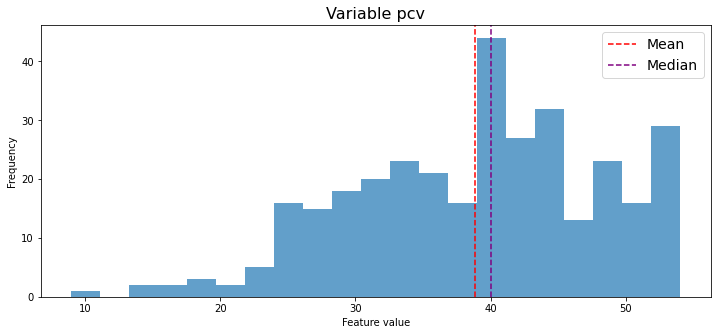

In [9]:
for col in good_columns:
    if pd.api.types.is_numeric_dtype( df[col] ) and col != "id":
        
        plt.figure(figsize=(12, 5))
        
        plt.hist( df[col], bins=21, alpha=0.7 )
        plt.title("Variable "+col, fontsize=16)
        
        plt.axvline( np.nanmean(df[col]), color="red", linestyle="--",label="Mean" )
        plt.axvline( np.nanmedian(df[col]), color="purple", linestyle="--",label="Median" )
        
        plt.ylabel("Frequency")
        plt.xlabel("Feature value")
        
        plt.legend(fontsize=14)
        
        plt.show()